In [136]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

from warnings import filterwarnings
filterwarnings("ignore")

In [137]:
fetch_california_housing().keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [138]:
data = fetch_california_housing()

In [139]:
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [183]:
california_df = pd.DataFrame(data.data, columns=data.feature_names)
california_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [184]:
california_df["MedHouseVal"] = data.target
california_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [185]:
california_df.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [186]:
X = california_df[["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "Latitude", "Longitude"]]
y = california_df["MedHouseVal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test)

(16512, 4128)

# Модель на основе всех неизмененных признаков

In [187]:
def print_metric_and_score(X, y, test_size=0.2, save_model: bool = False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"Score: {model.score(X_test, y_test)}")
    print(f"RMSE: {root_mean_squared_error(y_pred, y_test)}")
    print(f"R2 Score: {r2_score(y_pred, y_test)}")
    if save_model:
        pickle.dump(model, open("model.pickle", "wb+"))
        


print_metric_and_score(X, y, save_model=True)

Score: 0.5910509795491349
RMSE: 0.7356145375446771
R2 Score: 0.3441351848714451


In [188]:
california_df["MedHouseVal"].mean()

2.068558169089147

# Модель на обработанных данных

In [189]:
california_df["MedHouseVal"].describe()

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64

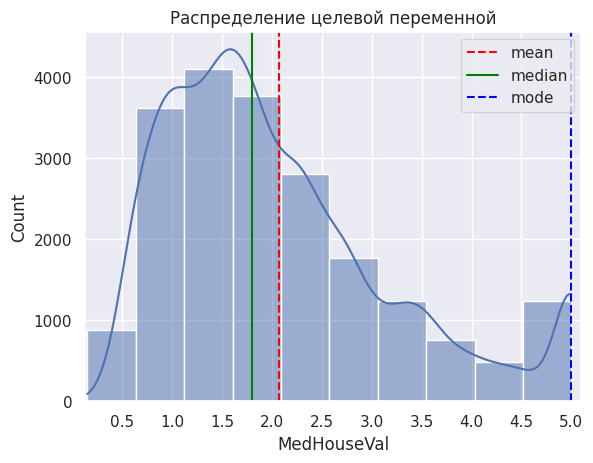

In [190]:
sns.set_theme()
sns.histplot(california_df["MedHouseVal"], bins=10, kde=True).set_title("Распределение целевой переменной")
plt.axvline (california_df["MedHouseVal"].mean(), color='red', linestyle='--', label="mean", ) 
plt.axvline (california_df["MedHouseVal"].quantile(0.5), color='green', label="median") 
plt.axvline (california_df["MedHouseVal"].mode().to_list()[0], color='blue', label="mode", linestyle='--') 
plt.xlim([0.13, 5.1])
plt.xticks([i/2 for i in range(1, 11)])
plt.legend()
plt.show()

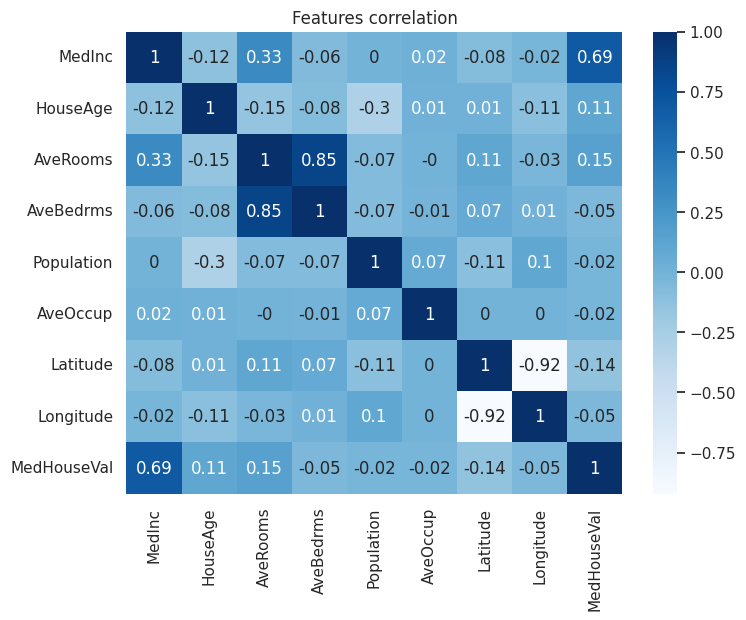

In [191]:
plt.figure(figsize=(8, 6))
plt.title("Features correlation")
sns.heatmap(california_df.corr().round(2), cmap="Blues", annot=True)
plt.show()

Видна сильная корреляция между AveRooms и AveBedrms, можно убрать AveBedrms

# Обработка целевого значения

In [192]:
len(california_df.query("MedHouseVal<5")), len(california_df)

(19648, 20640)

На графике распределения видно, что дома, стоимость которых > 5.0 меньше, чем в диапазоне от 1.0 до 2.0, можно избавиться от выбросов

In [193]:
california_df = california_df.query("MedHouseVal<5")

X = california_df[["MedInc", "HouseAge", "AveRooms", "Population", "AveOccup", "Latitude", "Longitude"]]
y = california_df["MedHouseVal"]


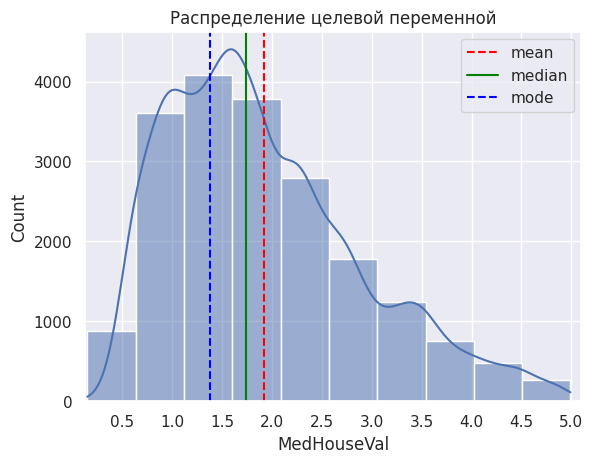

In [194]:
sns.set_theme()
sns.histplot(california_df["MedHouseVal"], bins=10, kde=True).set_title("Распределение целевой переменной")
plt.axvline (california_df["MedHouseVal"].mean(), color='red', linestyle='--', label="mean", ) 
plt.axvline (california_df["MedHouseVal"].quantile(0.5), color='green', label="median") 
plt.axvline (california_df["MedHouseVal"].mode().to_list()[0], color='blue', label="mode", linestyle='--') 
plt.xlim([0.13, 5.1])
plt.xticks([i/2 for i in range(1, 11)])
plt.legend()
plt.show()

# Работа с признаками

<Figure size 1600x1600 with 0 Axes>

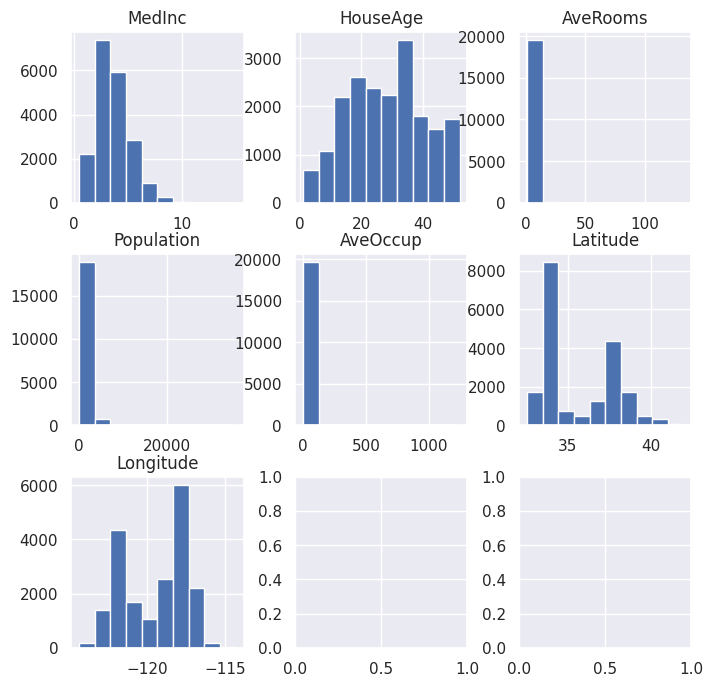

In [195]:
plt.figure(figsize=(16, 16))
fig, axs = plt.subplots(3, 3, figsize=(8, 8), gridspec_kw={'wspace': 0.3, 'hspace': 0.3})
columns = ["MedInc", "HouseAge", "AveRooms", "Population", "AveOccup", "Latitude", "Longitude"]
for i, ax in enumerate(axs.flat):
    if i < len(columns):
        ax.hist(california_df[columns[i]], bins=10)
        ax.set_title(columns[i])
plt.show()

Text(0.5, 1.0, 'MedInc')

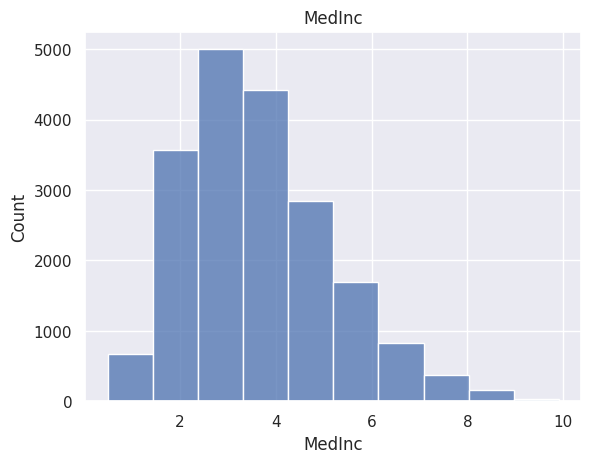

In [196]:
california_df = california_df.query("MedInc<10")
sns.set_theme()
sns.histplot(california_df["MedInc"], bins=10).set_title("MedInc")

Text(0.5, 1.0, 'AveRooms')

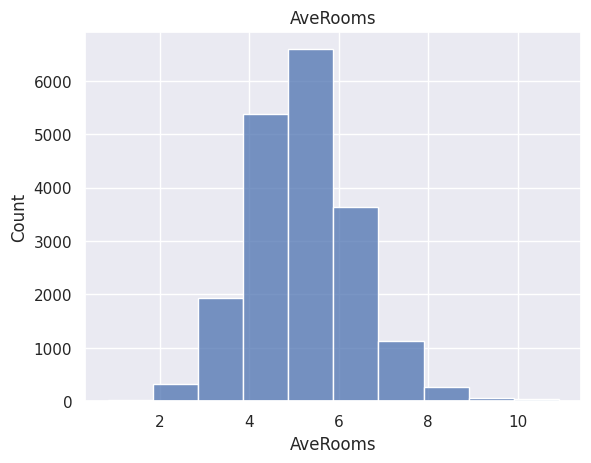

In [197]:
california_df = california_df.query("AveRooms<11")
sns.set_theme()
sns.histplot(california_df["AveRooms"], bins=10).set_title("AveRooms")

Text(0.5, 1.0, 'AveOccup')

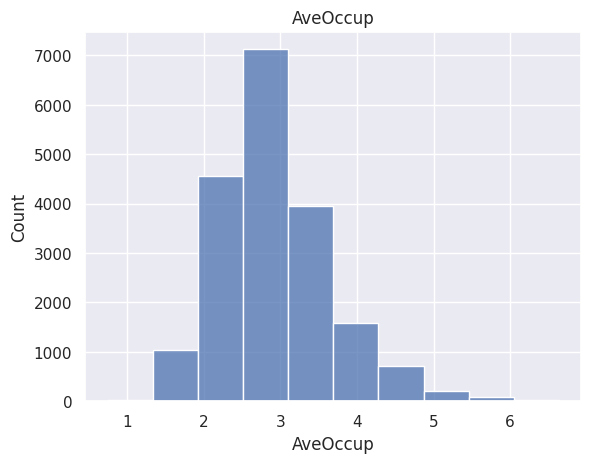

In [198]:
california_df = california_df.query("AveOccup<6.7")
sns.set_theme()
sns.histplot(california_df["AveOccup"], bins=10).set_title("AveOccup")

Text(0.5, 1.0, 'Population')

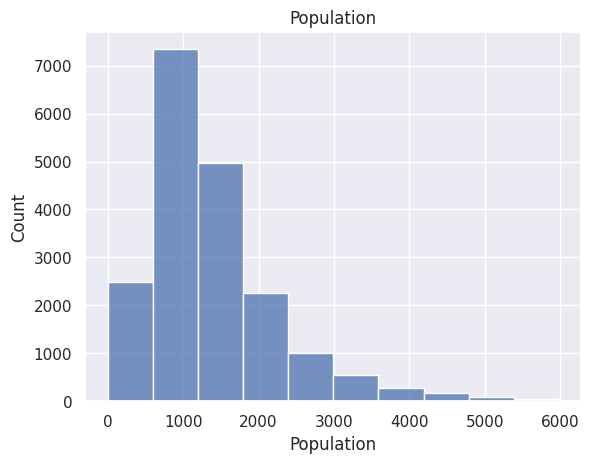

In [199]:
california_df = california_df.query("Population<6000")
sns.set_theme()
sns.histplot(california_df["Population"], bins=10).set_title("Population")

In [200]:
X = california_df[["MedInc", "HouseAge", "AveRooms", "Population", "AveOccup", "Latitude", "Longitude"]]
y = california_df["MedHouseVal"]
print_metric_and_score(X, y)

Score: 0.6241844580270777
RMSE: 0.5865161982692998
R2 Score: 0.4073353943939191


# Математическое изменение признаков

<Figure size 1600x1600 with 0 Axes>

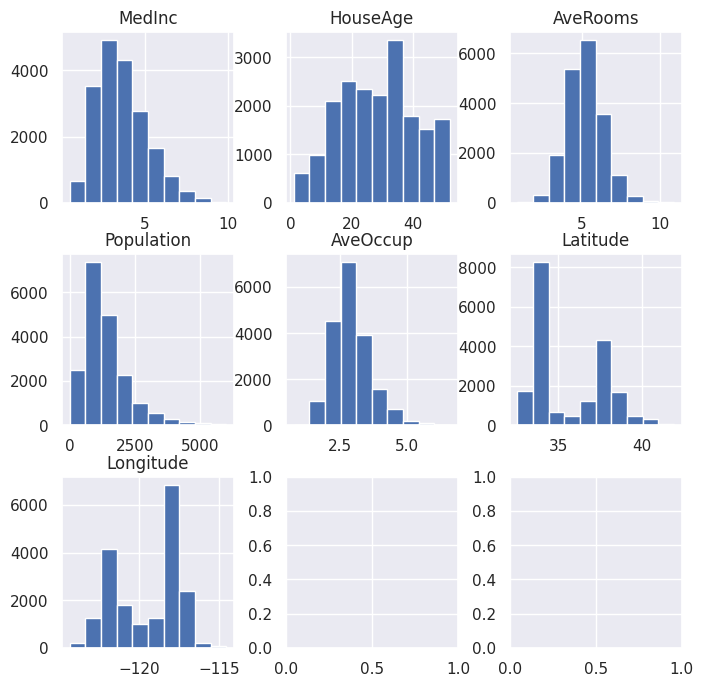

In [201]:
plt.figure(figsize=(16, 16))
fig, axs = plt.subplots(3, 3, figsize=(8, 8), gridspec_kw={'wspace': 0.3, 'hspace': 0.3})
columns = ["MedInc", "HouseAge", "AveRooms", "Population", "AveOccup", "Latitude", "Longitude"]
for i, ax in enumerate(axs.flat):
    if i < len(columns):
        ax.hist(california_df[columns[i]], bins=10)
        ax.set_title(columns[i])
plt.show()

In [202]:
test_math_df = california_df.copy()

<Figure size 1600x1600 with 0 Axes>

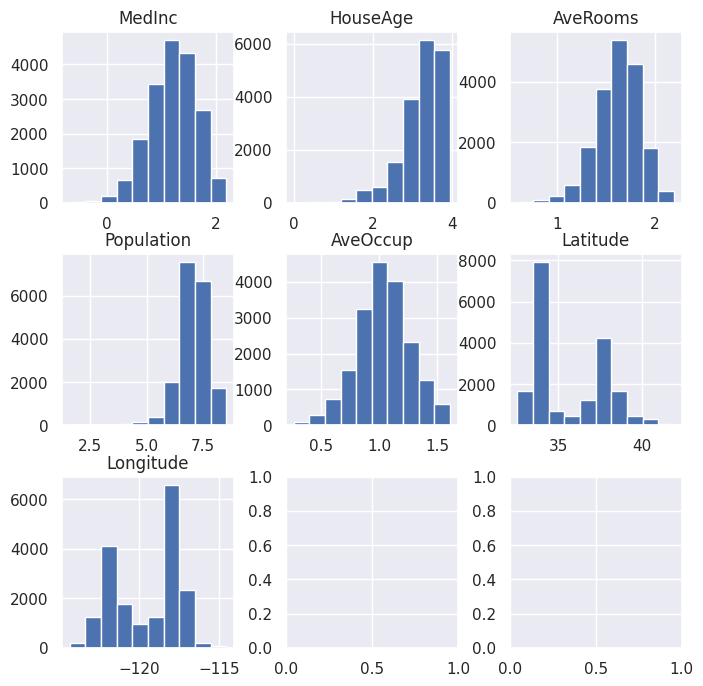

Score: 0.5996688689634218
RMSE: 0.6165046789854772
R2 Score: 0.31270482656418164


In [160]:
test_math_df["MedInc"] = np.log(california_df["MedInc"])
test_math_df["HouseAge"] = np.log(california_df["HouseAge"])
test_math_df["AveRooms"] = np.log(california_df["AveRooms"])
test_math_df["Population"] = np.log(california_df["Population"])
test_math_df["AveOccup"] = np.log(california_df["AveOccup"])

plt.figure(figsize=(16, 16))
fig, axs = plt.subplots(3, 3, figsize=(8, 8), gridspec_kw={'wspace': 0.3, 'hspace': 0.3})
columns = ["MedInc", "HouseAge", "AveRooms", "Population", "AveOccup", "Latitude", "Longitude"]
for i, ax in enumerate(axs.flat):
    if i < len(columns):
        ax.hist(test_math_df[columns[i]], bins=10)
        ax.set_title(columns[i])
plt.show()

X = test_math_df[["MedInc", "HouseAge", "AveRooms", "Population", "AveOccup", "Latitude", "Longitude"]]
y = test_math_df["MedHouseVal"]
print_metric_and_score(X, y)

<Figure size 1600x1600 with 0 Axes>

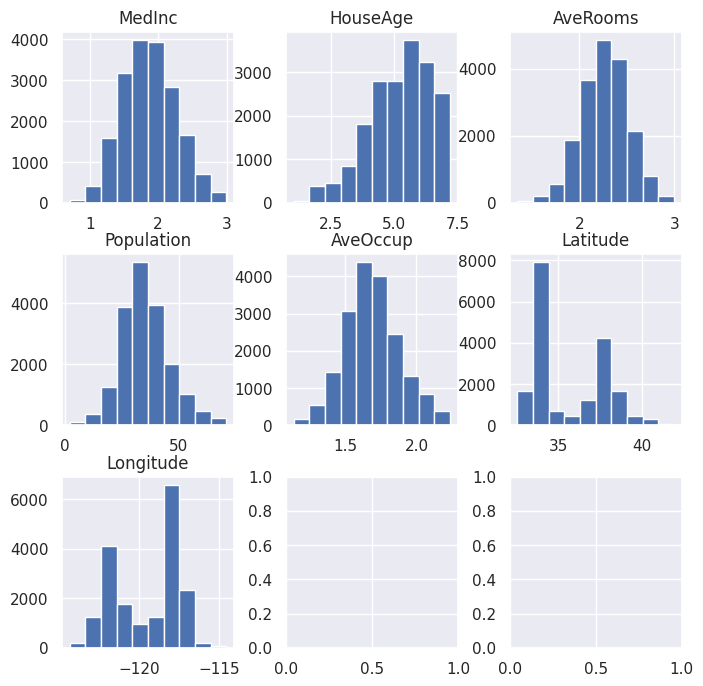

Score: 0.6256953229357431
RMSE: 0.5961277270379868
R2 Score: 0.39157690475762885


In [161]:
test_math_df["MedInc"] = np.sqrt(california_df["MedInc"])
test_math_df["HouseAge"] = np.sqrt(california_df["HouseAge"])
test_math_df["AveRooms"] = np.sqrt(california_df["AveRooms"])
test_math_df["Population"] = np.sqrt(california_df["Population"])
test_math_df["AveOccup"] = np.sqrt(california_df["AveOccup"])

plt.figure(figsize=(16, 16))
fig, axs = plt.subplots(3, 3, figsize=(8, 8), gridspec_kw={'wspace': 0.3, 'hspace': 0.3})
columns = ["MedInc", "HouseAge", "AveRooms", "Population", "AveOccup", "Latitude", "Longitude"]
for i, ax in enumerate(axs.flat):
    if i < len(columns):
        ax.hist(test_math_df[columns[i]], bins=10)
        ax.set_title(columns[i])
plt.show()

X = test_math_df[["MedInc", "HouseAge", "AveRooms", "Population", "AveOccup", "Latitude", "Longitude"]]
y = test_math_df["MedHouseVal"]
print_metric_and_score(X, y)

<Figure size 1600x1600 with 0 Axes>

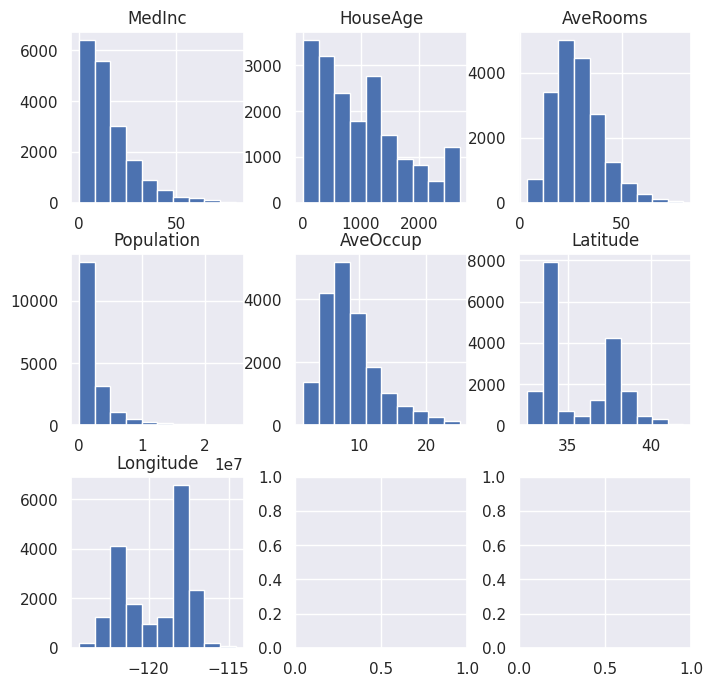

Score: 0.6262997777370045
RMSE: 0.595646197044881
R2 Score: 0.40231863291223025


In [162]:
test_math_df["MedInc"] = (california_df["MedInc"])**2
test_math_df["HouseAge"] = (california_df["HouseAge"])**2
test_math_df["AveRooms"] = (california_df["AveRooms"])**2
test_math_df["Population"] = (california_df["Population"])**2
test_math_df["AveOccup"] = (california_df["AveOccup"])**2

plt.figure(figsize=(16, 16))
fig, axs = plt.subplots(3, 3, figsize=(8, 8), gridspec_kw={'wspace': 0.3, 'hspace': 0.3})
columns = ["MedInc", "HouseAge", "AveRooms", "Population", "AveOccup", "Latitude", "Longitude"]
for i, ax in enumerate(axs.flat):
    if i < len(columns):
        ax.hist(test_math_df[columns[i]], bins=10)
        ax.set_title(columns[i])
plt.show()

X = test_math_df[["MedInc", "HouseAge", "AveRooms", "Population", "AveOccup", "Latitude", "Longitude"]]
y = test_math_df["MedHouseVal"]
print_metric_and_score(X, y)

# Проверка гипотез: зависимость стоимости от признаков

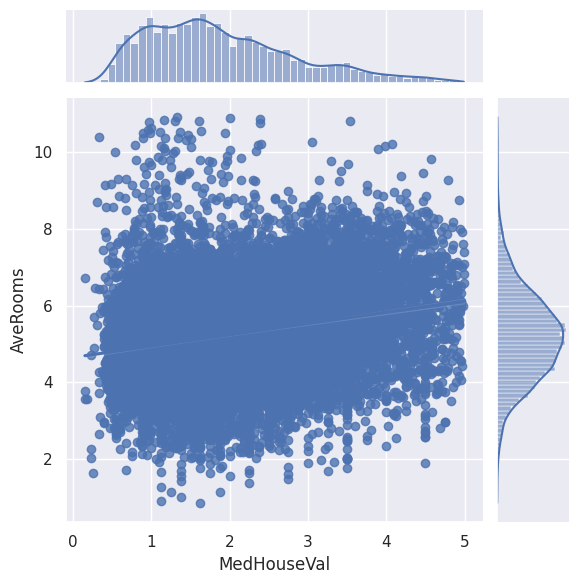

In [209]:
sns.jointplot(data=california_df, x="MedHouseVal", y="AveRooms", kind="reg")

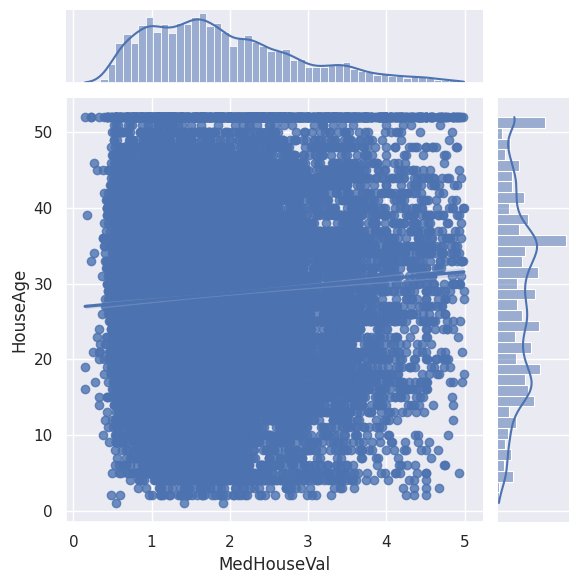

In [210]:
sns.jointplot(data=california_df, x="MedHouseVal", y="HouseAge", kind="reg")

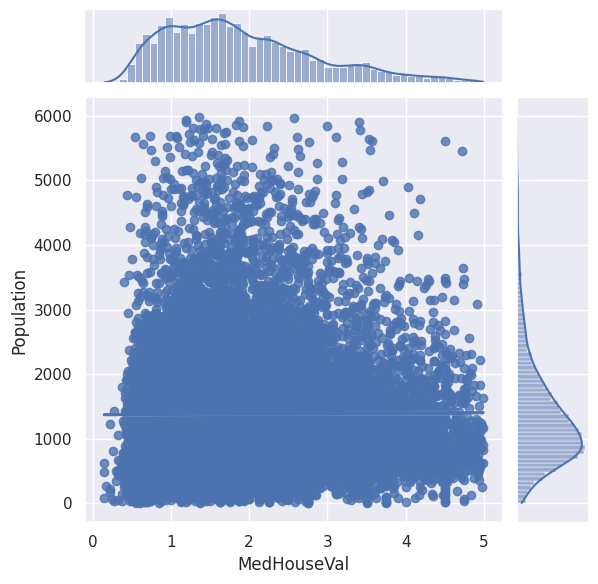

In [211]:
sns.jointplot(data=california_df, x="MedHouseVal", y="Population", kind="reg")

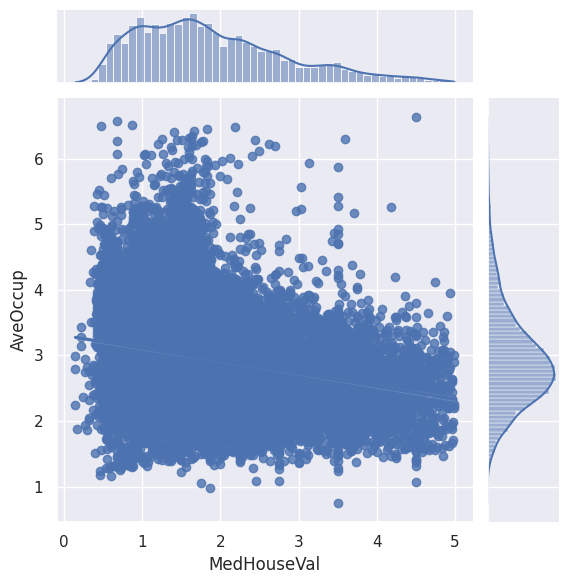

In [212]:
sns.jointplot(data=california_df, x="MedHouseVal", y="AveOccup", kind="reg")

# Выводы
1. Был удален признак AveBedrms, так как он сильно коррелирует с AveRooms. Также из данных были удалены выбросы
2. Лучше всего показала себя модель, обученная на обработанных данных. Мат операции в данном случае не пошли модели на пользу (возможно из за того, что они применялись на уже обработанные данные)
3. В целом результат предсказуемый. Возможно можно было создать новые фичи на основе существующих, но я не уловил таких связей.

# Метрики

| № |    MODEL        |  RMSE  |   R2   | FEATURES |
|---|-----------------|--------|--------|----------|
| 1 | Base model      | 0.7356 | 0.3441 |    ALL   |
| 2 | Clean data model| 0.5865 | 0.4073 | MedInc, HouseAge, AveRooms, Population, AveOccup, Latitude, Longitude   |
| 3 | Log model       | 0.6204 | 0.2998 | MedInc, HouseAge, AveRooms, Population, AveOccup, Latitude, Longitude   |
| 4 | Sqrt model      | 0.5975 | 0.3769 | MedInc, HouseAge, AveRooms, Population, AveOccup, Latitude, Longitude   |
| 5 | Sqr model       | 0.5959 | 0.3620 | MedInc, HouseAge, AveRooms, Population, AveOccup, Latitude, Longitude   |